`--- Day 5: Alchemical Reduction ---`

In [1]:
import unittest
import re

In [2]:
polymer = open('input.txt').read().strip()
print(f'polymer length is {len(polymer)}\npolymer = {polymer[:10]}...{polymer[-10:]}')

polymer length is 50000
polymer = bBkKQqgaAG...FJnZNnwxXW


# Construct tests

For example:
```
    In aA, a and A react, leaving nothing behind.
    In abBA, bB destroys itself, leaving aA. As above, this then destroys itself, leaving nothing.
    In abAB, no two adjacent units are of the same type, and so nothing happens.
    In aabAAB, even though aa and AA are of the same type, their polarities match, and so nothing happens.
```
Now, consider a larger example, dabAcCaCBAcCcaDA:
```
dabAcCaCBAcCcaDA  The first 'cC' is removed.
dabAaCBAcCcaDA    This creates 'Aa', which is removed.
dabCBAcCcaDA      Either 'cC' or 'Cc' are removed (the result is the same).
dabCBAcaDA        No further actions can be taken.
```
After all possible reactions, the resulting polymer contains 10 units.

In [3]:
testdata = {              'aA': '',
                        'abBA': '',
                        'abAB': 'abAB',
                      'aabAAB': 'aabAAB',
            'dabAcCaCBAcCcaDA': 'dabCBAcaDA'}

testdata2 = {'dabAcCaCBAcCcaDA': 'dabAaCBAcCcaDA',
               'dabAaCBAcCcaDA': 'dabCBAcCcaDA',
                 'dabCBAcCcaDA': 'dabCBAcaDA',
                   'dabCBAcaDA': 'dabCBAcaDA'}

testdata3 = {'dabAcCaCBAcCcaDA': 'dabAaCBAcaDA',
               'dabAaCBAcCcaDA': 'dabCBAcaDA',
                   'dabCBAcaDA': 'dabCBAcaDA'}

In [4]:
class TestIt(unittest.TestCase):
    # part 1
    def test_poly_reduce(self):
        for reducer in reducers:
            for test, res in testdata.items():
                with self.subTest(poly=test, reducer=reducer):
                    self.assertEqual(poly_reduce(test, reducer=reducer), res)
                
    def test_reduce_first(self):
        for test, res in testdata2.items():
            with self.subTest(poly=test):
                self.assertEqual(reduce_first(test), res)
                
    def test_reduce_all(self):
        for test, res in testdata3.items():
            with self.subTest(poly=test):
                self.assertEqual(reduce_all(test), res)
        

# Implement part 1 solution

In [5]:
rel = []
for c in 'abcdefghijklmnopqrstuvwxyz':
    rel.append(c + c.upper())
    rel.append(c.upper() + c)

reactive_units_re = re.compile('|'.join(rel))

def reduce_first(poly):
    return re.sub(reactive_units_re, '', poly, count=1)

def reduce_all(poly):
    return re.sub(reactive_units_re, '', poly)

def reduce_sequential(poly):
    for r in rel:
        poly = re.sub(r, '', poly)
    return poly

reducers = [reduce_first, reduce_all, reduce_sequential]

def poly_reduce(poly, reducer=reduce_sequential):
    last_length = len(poly) + 1 # start out with it not equal to len(poly)
    while last_length != len(poly):
        last_length = len(poly)
        poly = reducer(poly)
    return poly

# Run part 1 tests

In [6]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestIt)
unittest.TextTestRunner(verbosity=2).run(suite)

test_poly_reduce (__main__.TestIt) ... ok
test_reduce_all (__main__.TestIt) ... ok
test_reduce_first (__main__.TestIt) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.011s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Performance checks

In [7]:
test_poly = polymer[:10000]

In [8]:
%%timeit
res = poly_reduce(test_poly, reducer=reduce_sequential)

3.79 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%%timeit
res = poly_reduce(test_poly, reducer=reduce_all)

9.3 ms ± 545 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit
res = poly_reduce(test_poly, reducer=reduce_first)

706 ms ± 42.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Part 1 answer

In [11]:
%%timeit -n 1 -r 1
print(f'Part 1: {len(poly_reduce(polymer))}')

Part 1: 10598
450 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Part 2

In [12]:
%%timeit -n 1 -r 1
reduced_lengths = []
for c in 'abcdefghijklmnopqrstuvwxyz':
    r = f'[{c}{c.upper()}]' # '[aA]' etc.
    reduced_lengths.append(len(poly_reduce(re.sub(r ,'', polymer))))
print(f'Part 2: {min(reduced_lengths)}')

Part 2: 5312
12.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Performance analysis

In [27]:
from timeit import Timer
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [76]:
max_l = 2500 # len(polymer)
n_datapoints = 11

lengths = pd.Series(np.linspace(0, max_l, n_datapoints, dtype=np.int), name='PolymerLength')

data = [lengths]
for fun in reducers:
    print(f'Timing reducer {fun.__name__}...')
    perf = []
    print(f'lengths ', end='')
    for l in lengths:
        print(f'{l} ', end='')
        test_poly = polymer[:l]
        timer = Timer(f'poly_reduce(test_poly, reducer={fun.__name__})', globals=globals())
        iters, time = timer.autorange()
        perf.append(time / iters)
    print(f' - iters={iters}, time={time}')
    data.append(pd.Series(perf, name=fun.__name__))
print()

Timing reducer reduce_first...
lengths 0 250 500 750 1000 1250 1500 1750 2000 2250 2500  - iters=100, time=0.6804663287894073
Timing reducer reduce_all...
lengths 0 250 500 750 1000 1250 1500 1750 2000 2250 2500  - iters=1000, time=0.9132844535797631
Timing reducer reduce_sequential...
lengths 0 250 500 750 1000 1250 1500 1750 2000 2250 2500  - iters=1000, time=0.6896163845558476



In [77]:
df = pd.concat(data, axis=1)

In [78]:
df.head()

,PolymerLength,reduce_first,reduce_all,reduce_sequential
0,0,0.000002,0.000002,0.000049
1,250,0.000308,0.000073,0.000232
2,500,0.000604,0.000138,0.000224
3,750,0.001015,0.000205,0.000302
4,1000,0.001561,0.000291,0.000354


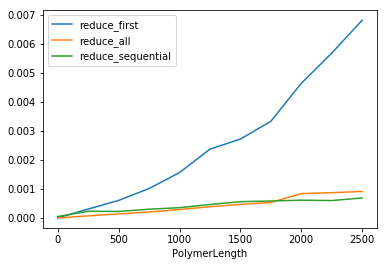

In [79]:
df.plot(x='PolymerLength')

In [80]:
df.to_csv(f'results_{max_l}.csv')

In [81]:
dfs = [pd.read_csv(f'results_{i}.csv', index_col=0) for i in [100, 1000, 2500, 50000]]

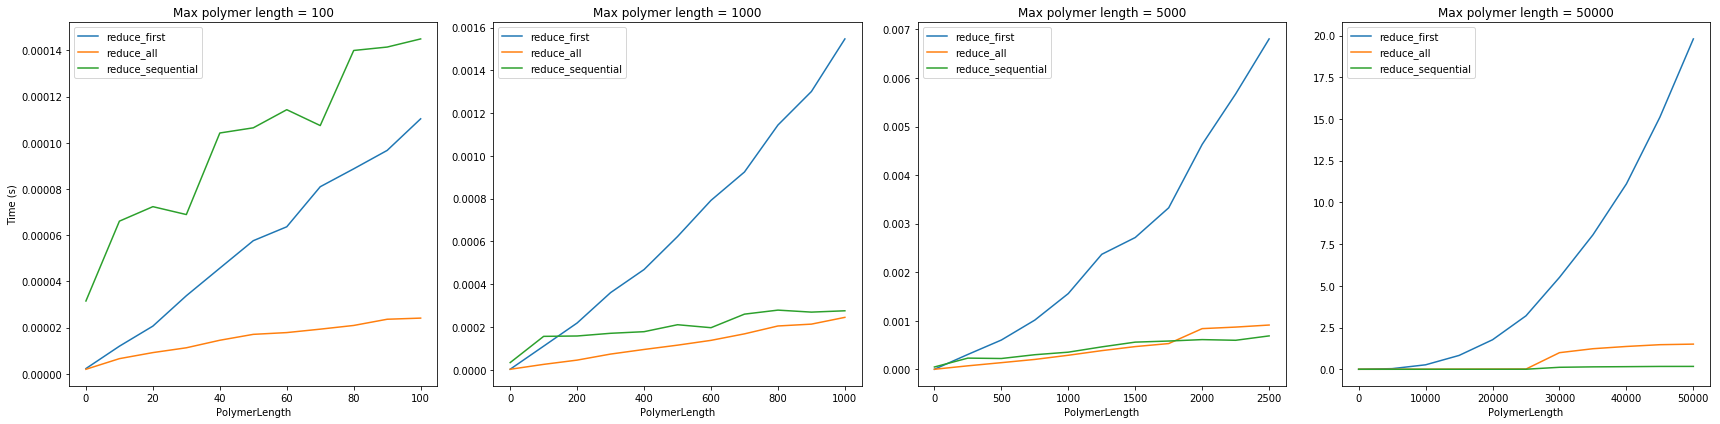

In [86]:
fig, ax = plt.subplots(1, 4, squeeze=True, figsize=(24,6))
for i, sdf in enumerate(dfs):
    sdf.plot(x='PolymerLength', ax=ax[i])
for i, N in enumerate([100, 1000, 5000, 50000]):
    ax[i].set_title(f'Max polymer length = {N}')
    
ax[0].set_ylabel('Time (s)')
plt.tight_layout()
plt.savefig('performance_comparison.png')
plt.show()